# Machine learning with the Open Data Cube

* **Products used:** 
[gm_s2_annual](https://explorer.digitalearth.africa/gm_s2_annual)
* **Special requirements:** A shapefile of labelled data is required to use this notebook.
An example dataset is provided.

* **Prerequisites:** A basic understanding of supervised learning techniques is required. 
    * [Introduction to statistical learning](https://link.springer.com/book/10.1007/978-1-0716-1418-1) is a useful resource to begin with - it can be downloaded for free [here](https://hastie.su.domains/ISLR2/ISLRv2_website.pdf). 
    * The [Scikit-learn](https://scikit-learn.org/stable/supervised_learning.html) documentation provides information on the available models and their parameters.
    * This [article](https://www.tandfonline.com/doi/full/10.1080/01431161.2018.1433343) provides a nice review of machine learning in the context of remote sensing.

> **Note**: For a more detailed exploration of machine learning on the ODC, see the notebook series: **Scalable machine learning in the ODC** in the `Real_world_examples/Scalable_machine_learning/` folder.

## Description

This notebook demonstrates a potential workflow using functions from the [deafrica_tools.classification](https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Tools/gen/deafrica_tools.classification.html) script to implement a `supervised learning` landcover classifier within the [ODC (Open Data Cube)](https://www.opendatacube.org/) framework. The notebook uses a default shapefile of training data (provided for demonstration purposes only) to classify `urban areas` in Kampala, Uganda

> **Note**: Users who have their own training data can directly import their own shapefile by uploading their shapefile into the Sandbox and adjusting the `path` parameter.

The notebook demonstrates how to:

1. Train a simple decision tree model and adjust parameters 
2. Predict urban areas using the trained model on new data
3. Evaluate the output of the classification using quantitative metrics
4. Plot the results and visually assess the classification
5. Export the results as a geotiff

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

# Force GeoPandas to use Shapely instead of PyGEOS
# In a future release, GeoPandas will switch to using Shapely by default.
import os
os.environ['USE_PYGEOS'] = '0'

import datacube
import warnings
import pydotplus
import numpy as np
import geopandas as gpd
from io import StringIO
from joblib import dump
from pprint import pprint
import matplotlib.pyplot as plt
from IPython.display import Image
from odc.io.cgroups import get_cpu_quota
from sklearn import tree, model_selection
from sklearn.metrics import accuracy_score
from datacube.utils.cog import write_cog

from deafrica_tools.plotting import map_shapefile, rgb
from deafrica_tools.classification import predict_xr, collect_training_data
from deafrica_tools.bandindices import calculate_indices


In [2]:
warnings.filterwarnings('ignore')

### Connect to the datacube

Connect to the datacube so we can access DE Africa data.

In [3]:
dc = datacube.Datacube(app='Machine_learning_with_ODC')

### Analysis parameters
* `lat`, `long` & `buffer`: The centre location and buffer for your area of interest, this will define the box from which we extract satellite data to classify when we make the prediction.
* `path`: The path to the input shapefile. A default shapefile is provided.
* `field`: This is the name of column in your shapefile attribute table that contains the class labels
* `product`: The name of the product to extract. In this example we use a Sentinel-2 geomedian composite from 2019, `'ga_s2_gm'`
* `time`: The time range you wish to extract data for, typically the same date the labels were created.
* `zonal_stats`: This is an option to calculate the `'mean'`, `'median'`, `'max'`, or `'min'` of the pixel values within each polygon feature, setting it to `None` will result in all pixels being extracted.
* `resolution`: The spatial resolution, in metres, to resample the satellite data too e.g. if working with Landsat data, then this should be `(-10,10)` 

**If running the notebook for the first time**, keep the default settings below. This will demonstrate how the analysis works and provide meaningful results.  

> If you decide to change any of the parameters below, then these changes will need to be reflected in the `Prediction` section. For the prediction section to work, it requires loading the same data as is loaded in the training data. The user needs to update the prediction section manually.

In [4]:
lat, long = 0.3109, 32.5943 # Kampala, Uganda
buffer = 0.1
path = '../Supplementary_data/Machine_learning_with_ODC/kampala_urban_labels.shp'
field = 'class'
products = 'gm_s2_annual'
measurements =  ['blue','green','red','nir','swir_1','swir_2', 'BCMAD', 'EMAD', 'SMAD']
time = ('2019')
zonal_stats = None #'median' 
resolution =  (-10, 10)

### Automatically detect the number of cpus


In [5]:
ncpus=round(get_cpu_quota())
print('ncpus = '+str(ncpus))

ncpus = 7


## Extract training data using a shapefile

**Training data** is the most important part of any machine learning workflow. The quality of the training data has a greater impact of the classification than the algorithm used. Large and accurate training data sets are preferable: increasing the training sample size results in increased classification accuracy (Huang, Davis and Townsend 2002).  

When creating training data, be sure to capture the `spectral variability` of the class, and to use imagery from the time period you want to classify (rather than relying on basemap composites). The best way to create training data is using a GIS platform. 

Another common problem with training data is `class imbalance`. This can occur when one of your classes is relatively rare and therefore the rare class will comprise a smaller proportion of the training set. When imbalanced data is used, it is common that the final classification will under-predict less abundant classes relative to their true proportion.

> **Note**: The training data provided by default is *for demonstration purposes only* and should not be relied upon for real world analysis.  

***

Firstly, let's open our input data and visualise it using the function `map_shapefile`. We can also check the shapefile by plotting and inspecting it. Note: The polygons are very small so you will need to zoom in to see them.

In [6]:
#open shapefile and ensure its in WGS84 coordinates
input_data = gpd.read_file(path).to_crs('epsg:4326')

#check the shapfile by plotting it
map_shapefile(input_data, attribute=field)

Label(value='')

Map(center=[-0.28806458596105367, 31.347375440203393], controls=(ZoomControl(options=['position', 'zoom_in_tex…

## Defining feature layers

To create the desired feature layers, we pass instructions to `collect_training_data` through the `feature_func` parameter.

* `feature_func`: A function for generating feature layers that is applied to the data within the bounds of the input geometry. The `feature_func` must accept a `dc_query` object, and return a single `xarray.Dataset` or `xarray.DataArray` containing 2D coordinates (i.e x, y - no time dimension). e.g.

          def feature_function(query):
              dc = datacube.Datacube(app='feature_layers')
              ds = dc.load(**query)
              ds = ds.mean('time')
              return ds

Below, we will define a feature layer function. We will load all the layers of the annual sentinel-2 [GeoMAD](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/master/Datasets/GeoMAD.ipynb), and then calculate some band indices.

In [7]:
def feature_layers(query):
    #connect to the datacube
    dc = datacube.Datacube(app='feature_layers')
    
    #load ls8 geomedian
    ds = dc.load(product=products,
                 **query)
    
    #calculate some band indices
    ds = calculate_indices(ds,
                           index=['NDVI', 'BUI', 'MNDWI'],
                           drop=False,
                           satellite_mission='s2')
    
    return ds

To train our model, we need to obtain satellite data that corresponds with the labelled input data locations. 

The function `collect_training_data` takes our shapefile, containing class labels, and extracts traning data from the datacube over the location specified by the input geometries. The function will also pre-process our training data by stacking the arrays into a useful format and removing an `NaN` (not-a-number) values.  Before we run the training data function, we first need to set up a dictionary with the satellite query parameters:


In [8]:
#generate a datacube query object
query = {
    'time': time,
    'measurements': measurements,
    'resolution': resolution,
    'output_crs' : 'epsg:6933'
}

> **The following cell can take several minutes to run.** The class labels will be contained in the first column of the output array.  If you set `ncpus > 1`, then this function will be run in parallel across the specified number of processes.

In [9]:
#Collect the training data from the datacube
column_names, model_input = collect_training_data(
                                    gdf=input_data,
                                    dc_query=query,
                                    ncpus=ncpus,
                                    field=field,
                                    zonal_stats=zonal_stats,
                                    feature_func=feature_layers
                                    )

  0%|          | 0/250 [00:00<?, ?it/s]

Percentage of possible fails after run 1 = 0.0 %
Removed 0 rows wth NaNs &/or Infs
Output shape:  (5076, 13)


In [10]:
print(column_names)
print('')
print(np.array_str(model_input, precision=2, suppress_small=True))

['class', 'blue', 'green', 'red', 'nir', 'swir_1', 'swir_2', 'BCMAD', 'EMAD', 'SMAD', 'NDVI', 'BUI', 'MNDWI']

[[   1.    972.   1151.   ...    0.01    0.16   -0.25]
 [   1.   1047.   1326.   ...    0.08    0.     -0.24]
 [   1.    818.   1036.   ...    0.23   -0.14   -0.42]
 ...
 [   0.    371.    414.   ...   -0.1    -0.16    0.45]
 [   0.    374.    424.   ...   -0.09   -0.19    0.47]
 [   0.    379.    429.   ...   -0.08   -0.22    0.47]]


So that we can assess the accuracy of our classification, we split our data into training and testing data. 
80% is used for training with 20% held back for testing.
When splitting our data, we stratify the training data by the distributions of class membership.
This sampling method leads to a similar distribution of class membership in the training data.

In [11]:
# Split into training and testing data
model_train, model_test = model_selection.train_test_split(model_input, 
                                                           stratify=model_input[:, 0],
                                                           train_size=0.8, 
                                                           random_state=0)
print("Train shape:", model_train.shape)
print("Test shape:", model_test.shape)

Train shape: (4060, 13)
Test shape: (1016, 13)


## Model preparation

This section automatically creates a list of varaible names and their respective indices for each of the training data variables.

> **Note:** To use a custom subset of the satellite bands loaded above to train our data, you can replace `column_names[1:]` with a list of selected band names (e.g. `['red', 'green', 'blue']`)

In [12]:
# Select the variables we want to use to train our model
model_variables = column_names[1:]

# Extract relevant indices from the processed shapefile
model_col_indices = [column_names.index(var_name) for var_name in model_variables]

A **decision tree model** is chosen as it is one of the simplest supervised machine learning models we can implement. 

Its strengths are its explainability and cheap computational cost.

Parameter tuning can be conducted in the model initialisation below by adding or changing variables in the `classifier_params` below - details on how the different parameters will affect the model are [here](https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use).

In [13]:
classifier_params = {'criterion': 'gini',
                     'max_depth' : 10,
                     'splitter' : 'random',
                     'min_samples_split' : 100}

model = tree.DecisionTreeClassifier(**classifier_params, random_state=1)

## Train model

The model is fitted / trained using the prepared training data. 
The fitting process uses the decision tree approach to create a generalised representation of reality based on the training data. 
This fitted / trained model can then be used to predict which class new data belongs to.

In [14]:
# Train model
model.fit(model_train[:, model_col_indices], model_train[:, 0])

DecisionTreeClassifier(max_depth=10, min_samples_split=100, random_state=1,
                       splitter='random')

### Optionally save the model

Running this cell will export the classifier as a binary`.joblib` file. This will allow for importing the model in other scripts should we wish to use the same model to classify a different region.

To import a saved model, execute the following code snippet:

    from joblib import load
    ml_model = 'ml_model.joblib'
    model = load(ml_model)

In [15]:
dump(model, 'ml_model.joblib')

['ml_model.joblib']

---

## Evaluating Classifier

The following cells will help you examine the classifier and improve the results.  We can do this by:
* Determining our overall accuracy,
* Finding out which features (bands in the input data) are most useful for classifying, and which are not,
* Plotting the Decision Tree to help us understand which thresholds are used to seperate the classes.

### Overall Accuracy

We can use the 20% sample of test data we partitioned earlier to test the accuracy of the trained model on this new, "unseen" data.

An accuracy value of 1.0 indicates that the model was able to correctly predict 100% of the classes in the test data.

In [16]:
predictions = model.predict(model_test[:, model_col_indices])
str(round(accuracy_score(predictions, model_test[:, 0]), 2) *100) + ' %'

'100.0 %'

### Determine Feature Importance

Extract classifier estimates of the relative importance of each band/variable for training the classifier. Useful for potentially selecting a subset of input bands/variables for model training/classification (i.e. optimising feature space). Results will be presented in descending order with the most important features listed first.  Importance is reported as a relative fraction between 0 and 1.

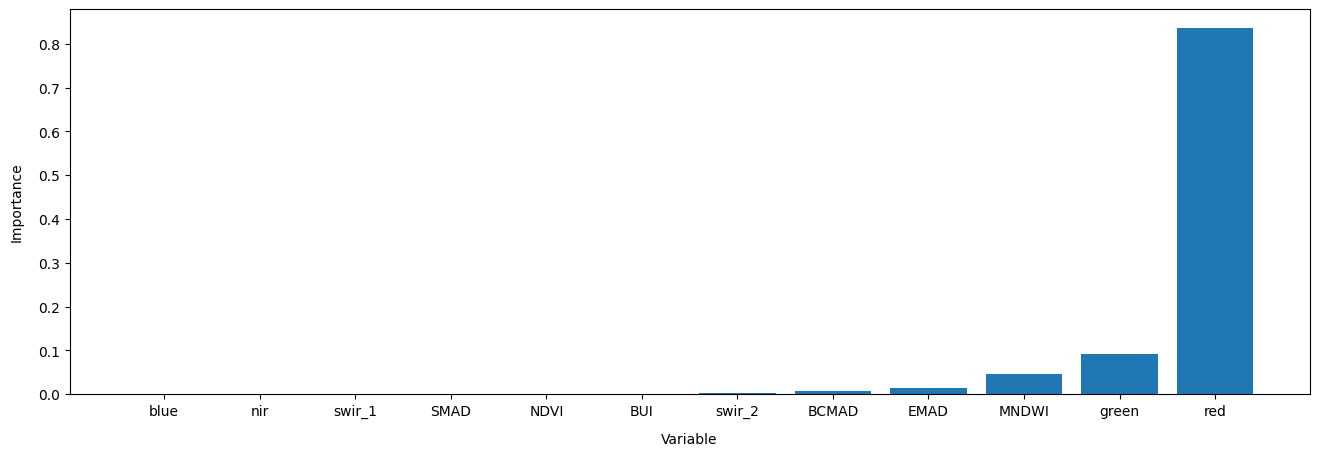

In [17]:
# This shows the feature importance of the input features for predicting the class labels provided
order = np.argsort(model.feature_importances_)

plt.figure(figsize=(16,5))
plt.bar(x=np.array(model_variables)[order],
        height=model.feature_importances_[order])
plt.gca().set_ylabel('Importance', labelpad=10)
plt.gca().set_xlabel('Variable', labelpad=10);

### Plot the Decision Tree

This decision tree representation visualises the trained model. 
Here we can see that the model decides which landcover class to assign based on the value of the important variables in the plot above.

The **gini** (or **entropy**) value shown in the tree represents the decrease in node impurity.
This can also be understood as how heterogeneous the labels are (small values indicating better results). 
This metric is used by the decision tree to determine how to split the data into smaller groups.

> This step can take a long time if using `feature_stats = None`

If the graph is small double-click to enlarge it. Double-click again to return to initial size.

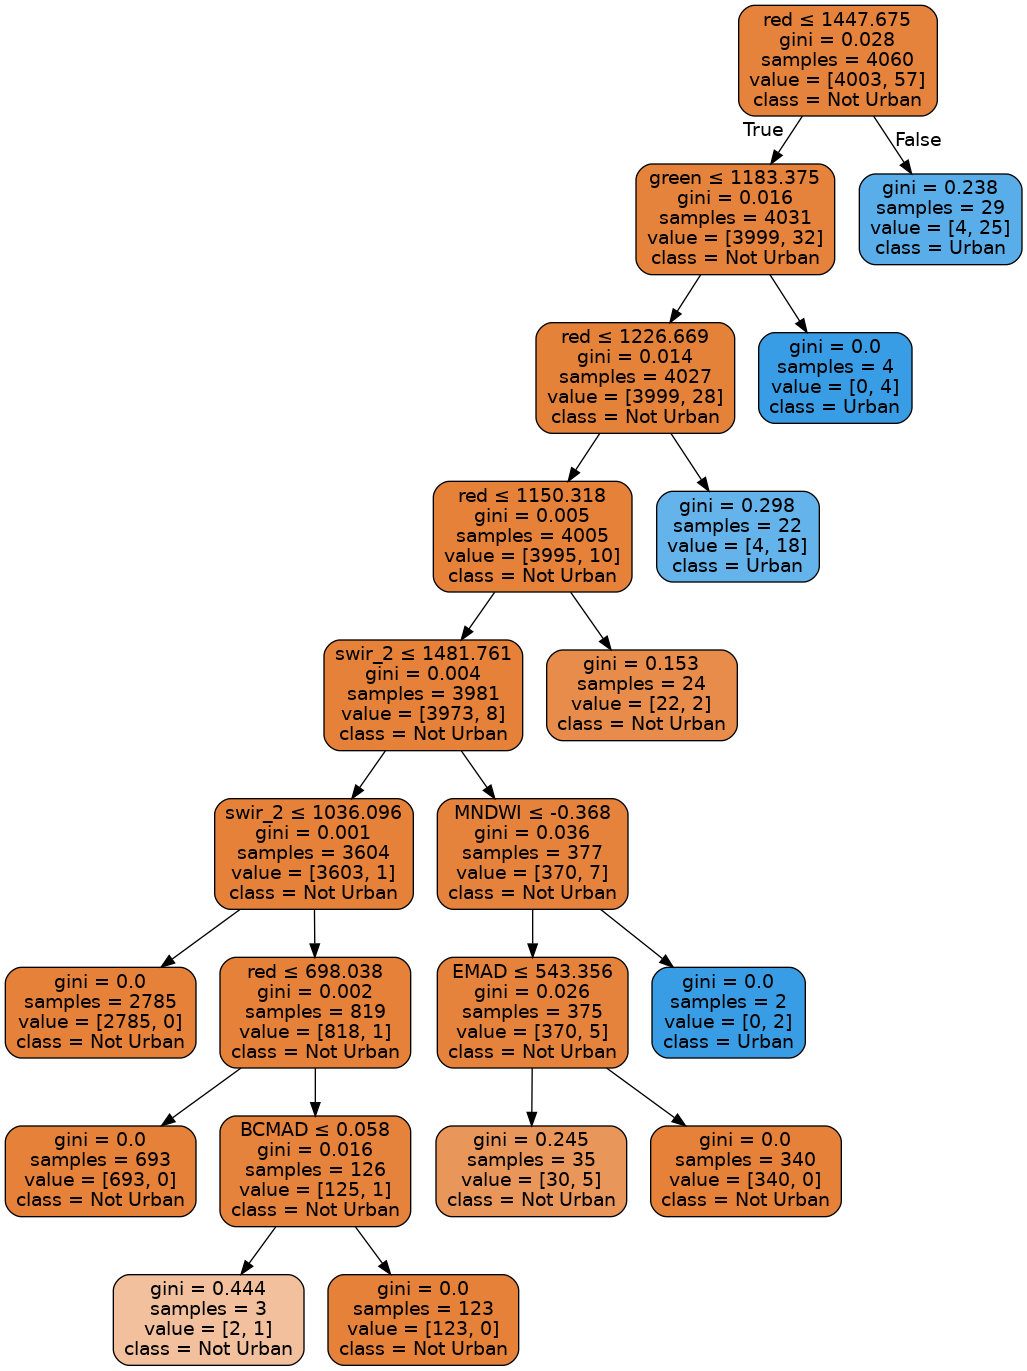

In [18]:
# Prepare a dictionary of class names
class_names = {1: 'Urban',
               0: 'Not Urban'}

# Get list of unique classes in model
class_codes = np.unique(model_train[:, 0])
class_names_in_model = [class_names[k] for k in class_codes]

# Plot decision tree
dot_data = StringIO()
tree.export_graphviz(model, 
                     out_file=dot_data, 
                     feature_names=model_variables, 
                     class_names=class_names_in_model,
                     filled=True, 
                     rounded=True,
                     special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph = Image(graph.create_png())
graph

## Prediction

Now that we have a trained model, we can load new data and use the `predict_xr` function to predict landcover classes. 

The trained model can technically be used to classify any dataset or product with the same bands as the data originally used to train the data.
However, it is typically highly advisable to classify data from the same product that the data was originally trained on.

> If you changed any of the parameters in the `Analysis Parameters` section from their default values, then these changes will need to be reflected in the code below. For the prediction section to work, it requires loading the same data as is loaded in the training data. The user needs to update this section manually.


In [19]:
# Load the data based on query around the user supplied
# lat/long and buffer 
q = {'x': (long-buffer, long+buffer),
     'y': (lat+buffer, lat-buffer)}

query.update(q)

#calculate features
data = feature_layers(query)
data = data.where(data!=0, np.nan)

print(data)

<xarray.Dataset>
Dimensions:      (time: 1, y: 2552, x: 1931)
Coordinates:
  * time         (time) datetime64[ns] 2019-07-02T11:59:59.999999
  * y            (y) float64 5.242e+04 5.24e+04 5.24e+04 ... 2.692e+04 2.69e+04
  * x            (x) float64 3.135e+06 3.135e+06 ... 3.155e+06 3.155e+06
    spatial_ref  int32 6933
Data variables:
    blue         (time, y, x) float64 744.0 697.0 591.0 ... 354.0 391.0 375.0
    green        (time, y, x) float64 1.081e+03 1.076e+03 947.0 ... 642.0 621.0
    red          (time, y, x) float64 1.626e+03 1.522e+03 ... 499.0 468.0
    nir          (time, y, x) float64 2.465e+03 2.709e+03 ... 3.252e+03
    swir_1       (time, y, x) float64 2.944e+03 2.962e+03 ... 2.011e+03
    swir_2       (time, y, x) float64 2.369e+03 2.252e+03 ... 1.109e+03
    BCMAD        (time, y, x) float32 0.05101 0.04906 ... 0.04856 0.05198
    EMAD         (time, y, x) float32 762.0 720.6 668.8 ... 668.1 749.7 782.8
    SMAD         (time, y, x) float32 0.00134 0.001616 ... 0.0

In [20]:
# Predict landcover using the trained model
predicted = predict_xr(model, data, clean=True)

predicting...


## Plotting

To qualitatively evaluate how well the classification performed, we can plot the classifed/predicted data next to our input satellite imagery.

> **Note:** The output below is unlikely to be optimal the first time the classification is run.
The model training process is one of experimentation and assumption checking that occurs in an iterative cycle - Use the `Evaluate Classifier` steps below to help you improve the model

In [ ]:
# Set up plot
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot classified image
predicted.Predictions.plot(ax=axes[0], 
               cmap='viridis', 
               add_labels=False, 
               add_colorbar=False)

# Plot true colour image
rgb(data, ax=axes[1], percentile_stretch=(0.01, 0.99))

# Remove axis on right plot
axes[1].get_yaxis().set_visible(False)

# Add plot titles
axes[0].set_title('Classified Image (yellow = Urban)')
axes[1].set_title('True Colour Image of Kampala, Uganda')
plt.tight_layout();

## Exporting classification
We can now export the predicted landcover out to a GeoTIFF `.tif` file. 
This file can be loaded into GIS software (e.g. QGIS, ArcMap) to be inspected more closely.

In [22]:
write_cog(predicted.Predictions,
          fname="predicted.tif",
          overwrite=True)

PosixPath('predicted.tif')

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [23]:
print(datacube.__version__)

1.8.12


**Last Tested:**

In [24]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2023-04-16'